In [6]:
# ANOVA Based Power Analysis - Using IBD - HMP2 - Cedars Sinai Cohort
# By: Ashok K. Sharma
# Date: 10-29-2024

In [7]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.stats.power import FTestAnovaPower
from statsmodels.regression.mixed_linear_model import MixedLM

import warnings
warnings.filterwarnings("ignore")

In [8]:
# Rscipt was used to process IBD datasets to compute Diversity
#Rscript ~Process_IBD_files.R

# Load the Diversity File: Diversity.csv

import pandas as pd
def load_data_from_csv(file_path):
    try:
        df = pd.read_csv(file_path)
        print(f"Data loaded successfully from {file_path}")
        return df
    except FileNotFoundError:
        print("File not found. Please check the file path.")
        return None

#file_path = "../data/CS_diversity.csv"  # Specify the file path here
file_path = "../data/Diversity.csv"  # Specify the file path here

df = load_data_from_csv(file_path)

Data loaded successfully from ../data/Diversity.csv


In [9]:
df

,Sample,Obs,Shannon,InvSimpson,Project,Patient,week_num,visit_num,site_name,Age,diagnosis,hbi,sccai,fecalcal,Group
0,CSM5FZ3N_P,75,2.566304,9.976153,G79889,C3001,0,4,Cedars-Sinai,28.0,CD,4.0,NaN,193.89,CDUC
1,CSM5FZ3R_P,107,2.397691,8.663442,G79894,C3001,2,5,Cedars-Sinai,28.0,CD,4.0,NaN,133.01,CDUC
2,CSM5FZ3T_P,43,2.248977,8.058431,G79914,C3002,0,4,Cedars-Sinai,47.0,CD,9.0,NaN,179.22,CDUC
3,CSM5FZ3V_P,99,2.426909,8.771115,G79913,C3001,6,7,Cedars-Sinai,28.0,CD,5.0,NaN,46.86,CDUC
4,CSM5FZ3X_P,73,2.318691,8.243487,G79929,C3002,2,5,Cedars-Sinai,47.0,CD,7.0,NaN,71.48,CDUC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633,PSMB4MBS,129,2.786608,10.820095,G110702,P6037,33,21,MGH Pediatrics,15.0,CD,1.0,NaN,NaN,CDUC
1634,PSMB4MC1,134,2.789777,11.438235,G111932,P6038,34,22,MGH Pediatrics,8.0,UC,NaN,0.0,NaN,CDUC
1635,PSMB4MC3,114,2.577151,10.097963,G111934,P6038,35,23,MGH Pediatrics,8.0,UC,NaN,0.0,NaN,CDUC
1636,PSMB4MC5,97,2.941731,14.494684,G110704,P6038,37,25,MGH Pediatrics,8.0,UC,NaN,2.0,NaN,CDUC


In [10]:
print (df["site_name"].value_counts())
df['diagnosis'].value_counts ()

site_name
Cincinnati        482
MGH               451
Cedars-Sinai      413
MGH Pediatrics    229
Emory              63
Name: count, dtype: int64


diagnosis
CD        750
UC        459
nonIBD    429
Name: count, dtype: int64

Welcome to the Sample Size Estimation Tool!
1. Normal dataset (no repeated measures)
2. Longitudinal dataset (repeated measures) - include ICC?
3. Longitudinal dataset (repeated measures) - remove covariate effects and include ICC


Please choose the type of dataset analysis (1, 2, or 3):  1


Data loaded successfully from ../data/CS_diversity.csv
Columns available in the dataset:
1. Subject_ID
2. Obs
3. Shannon
4. InvSimpson
5. Project
6. Patient
7. week_num
8. visit_num
9. site_name
10. Age
11. diagnosis
12. hbi
13. sccai
14. fecalcal
15. Group


Please enter the column number you want to use for power calculation (default: Shannon):  Shannon


No valid column selected, defaulting to 'Shannon'.
Performing basic ANOVA-based sample size estimation...
Sample Size per group (Power: 70.0%, Effect Size: 0.80): 12
Sample Size per group (Power: 80.0%, Effect Size: 0.80): 15
Sample Size per group (Power: 90.0%, Effect Size: 0.80): 19
Plot saved: sample_size_vs_power_Basic_ANOVA.png


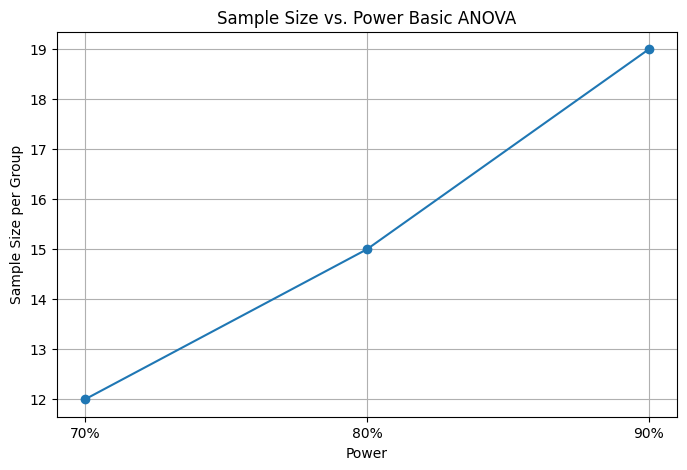

In [12]:
# Anova Based Standard Statistical Analysis

# Load CSV data
def load_data_from_csv(file_path):
    try:
        df = pd.read_csv(file_path)
        print(f"Data loaded successfully from {file_path}")
        return df
    except FileNotFoundError:
        print("File not found. Please check the file path.")
        return None

# Function to check covariates
def check_covariates(df, covariates):
    missing_covariates = [cov for cov in covariates if cov not in df.columns]
    if missing_covariates:
        print(f"Warning: The following covariates are not present in the dataset: {', '.join(missing_covariates)}")
    return len(missing_covariates) == 0

# Function to ask the user for the column to use
def ask_column_for_power_calculation(df):
    print("Columns available in the dataset:")
    for i, col in enumerate(df.columns):
        print(f"{i + 1}. {col}")
    
    column_choice = input("Please enter the column number you want to use for power calculation (default: Shannon): ")
    
    if column_choice.isdigit():
        column_choice = int(column_choice) - 1
        if column_choice >= 0 and column_choice < len(df.columns):
            return df.columns[column_choice]
    
    # Default to 'Shannon' if no valid input or input is empty
    print("No valid column selected, defaulting to 'Shannon'.")
    return 'Shannon'

# Function to calculate ICC (Intraclass Correlation Coefficient)
def calculate_icc(model, residual_variance):
    random_effect_variance = model.cov_re.iloc[0, 0]  # Variance of random effects
    total_variance = random_effect_variance + residual_variance
    icc = random_effect_variance / total_variance
    return icc

# Function to calculate adjusted effect size based on residual variance
def calculate_adjusted_effect_size(df, residual_variance, column_name):
    group_data = [df[df['diagnosis'] == grp][column_name] for grp in df['diagnosis'].unique()]
    group_means = [np.mean(group) for group in group_data]
    group_sizes = [len(group) for group in group_data]
    ss_between = np.sum([n * (mean - np.mean(df[column_name]))**2 for n, mean in zip(group_sizes, group_means)])
    eta_squared_adjusted = ss_between / (ss_between + residual_variance)
    return np.sqrt(eta_squared_adjusted)

# Function to perform ANOVA-based sample size calculation
def sample_size_anova(effect_size, num_groups, alpha=0.05, power=0.8):
    analysis = FTestAnovaPower()
    sample_size_per_group = analysis.solve_power(effect_size=effect_size, nobs=None, alpha=alpha, power=power, k_groups=num_groups)
    return int(np.ceil(sample_size_per_group))

# Function to adjust sample size for ICC
def adjust_sample_size_for_icc(n, m, icc):
    return n / (1 + (m - 1) * icc)

# Plot for each condition
def plot_sample_size(power_levels, sample_sizes, icc=None, title_suffix=""):
    plt.figure(figsize=(8, 5))
    
    if icc is not None:
        plt.plot(power_levels, [sample_sizes[power] for power in power_levels], marker='o')
        plt.title(f'Sample Size vs. Power (ICC {icc:.2f}) {title_suffix}')
    else:
        plt.plot(power_levels, [sample_sizes[power] for power in power_levels], marker='o')
        plt.title(f'Sample Size vs. Power {title_suffix}')
    
    plt.xlabel('Power')
    plt.ylabel('Sample Size per Group')
    plt.xticks([0.7, 0.8, 0.9], labels=["70%", "80%", "90%"])
    plt.grid(True)
    plt.savefig(f'sample_size_vs_power_{title_suffix.replace(" ", "_")}.png')
    print(f"Plot saved: sample_size_vs_power_{title_suffix.replace(' ', '_')}.png")
    plt.show()

# =================== USER INTERFACE ===================

# Ask the user for input
print("Welcome to the Sample Size Estimation Tool!")
print("1. Normal dataset (no repeated measures)")
print("2. Longitudinal dataset (repeated measures) - include ICC?")
print("3. Longitudinal dataset (repeated measures) - remove covariate effects and include ICC")

choice = input("Please choose the type of dataset analysis (1, 2, or 3): ")

file_path = "../data/CS_diversity.csv"  # Specify the file path here
df = load_data_from_csv(file_path)
### If only want to consider CD Samples (NOT UC)
df = df[df['diagnosis'] != 'UC']

# Ask user for the column to use in power calculations
selected_column = ask_column_for_power_calculation(df)

if choice == "1":
    # Basic ANOVA-based Sample Size Calculation (no repeated measures, no ICC, no covariates)
    print("Performing basic ANOVA-based sample size estimation...")
    residual_variance = np.var(df[selected_column])  # Total variance
    effect_size = calculate_adjusted_effect_size(df, residual_variance, selected_column)
    num_groups = len(df['diagnosis'].unique())
    power_levels = [0.7, 0.8, 0.9]

    sample_sizes_basic = {}

    for power in power_levels:
        n = sample_size_anova(effect_size, num_groups, power=power)
        sample_sizes_basic[power] = n
        print(f"Sample Size per group (Power: {power * 100}%, Effect Size: {effect_size:.2f}): {n}")

    # Plot sample size vs. power (Basic ANOVA)
    plot_sample_size(power_levels, sample_sizes_basic, title_suffix="Basic ANOVA")

elif choice == "2":
    # Longitudinal Data with ICC Adjustment
    print("Performing sample size estimation for longitudinal data with ICC adjustment...")

    # Fit mixed-effects model without covariates
    model = mixedlm(f"{selected_column} ~ diagnosis ", df, groups=df["Patient"]).fit()
    print(model.summary())

    # Calculate ICC from the model
    residual_variance = model.scale
    icc_value = calculate_icc(model, residual_variance)

    sample_sizes_icc = {}

    # Calculate adjusted effect size
    effect_size = calculate_adjusted_effect_size(df, residual_variance, selected_column)

    num_groups = len(df['diagnosis'].unique())
    num_timepoints = len(df['Patient'].unique())
    power_levels = [0.7, 0.8, 0.9]

    for power in power_levels:
        n = sample_size_anova(effect_size, num_groups, power=power)
        n_effective = adjust_sample_size_for_icc(n, num_timepoints, icc_value)
        sample_sizes_icc[power] = int(np.ceil(n_effective))
        print(f"Sample Size per group (Power: {power * 100}%, Effect Size: {effect_size:.2f}, ICC: {icc_value:.2f}): {n_effective:.2f}")

    # Plot sample size vs. power for the ICC condition
    plot_sample_size(power_levels, sample_sizes_icc, icc=icc_value, title_suffix="Longitudinal ICC")

elif choice == "3":
    # Longitudinal Data with ICC and Covariate Adjustment
    print("Performing sample size estimation for longitudinal data with covariate adjustment and ICC...")
    
    covariates = input("Please enter the covariates to adjust for (comma-separated, e.g., Antibiotic_Use,Illness,Diet): ").split(',')
    
    # Check if covariates exist in the dataframe
    if check_covariates(df, covariates):
        covariate_formula = " + ".join(covariates)

        # Fit mixed-effects model with covariates
        formula = f"{selected_column} ~ diagnosis + {covariate_formula}"
        model = mixedlm(formula, df, groups=df["Patient"]).fit()
        print(model.summary())

        # Calculate ICC from the model
        residual_variance = model.scale
        icc_value = calculate_icc(model, residual_variance)

        sample_sizes_cov_icc = {}

        # Calculate adjusted effect size
        effect_size = calculate_adjusted_effect_size(df, residual_variance, selected_column)

        num_groups = len(df['diagnosis'].unique())
        num_timepoints = len(df['Patient'].unique())
        power_levels = [0.7, 0.8, 0.9]

        for power in power_levels:
            n = sample_size_anova(effect_size, num_groups, power=power)
            n_effective = adjust_sample_size_for_icc(n, num_timepoints, icc_value)
            sample_sizes_cov_icc[power] = int(np.ceil(n_effective))
            print(f"Sample Size per group (Power: {power * 100}%, Effect Size: {effect_size:.2f}, ICC: {icc_value:.2f}): {n_effective:.2f}")

        # Plot sample size vs. power for longitudinal data with covariate adjustment
        plot_sample_size(power_levels, sample_sizes_cov_icc, icc=icc_value, title_suffix="Longitudinal ICC with Covariates")
    
    else:
        print("Please check the covariate names and try again.")

else:
    print("Invalid choice. Please run the script again and choose a valid option.")